In [1]:
!curl --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:67.0) Gecko/20100101 Firefox/67.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --header 'Upgrade-Insecure-Requests: 1' 'https://storage.googleapis.com/kaggle-datasets/18/2157/amazon-fine-food-reviews.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1559384929&Signature=aB5Hh4lnq1PBPpvMX4iETE7QGjI2JW4QuwvFHovmCg2h9iT3QizWufBQyOAAGxlHo4999b%2FRjVdPk%2FcwbFuu4lwBUUWz9WJS%2FA52FmF53XhV3WhYCkRokeVUCNuvJ1e6KBHXuEp2Qg3x4JXhp6MEuKMdDddvAIpMKnABiR6%2F2k9qUYF6cXVhhabx6PQ%2FERtv3K7DOBOlx4XgUrgoLM03FhVrs41qwYv3cTv922zYE6xBV%2BN%2BH8QA7P50SLludlaJtMGnmO%2Brq11OwSsSaoqLSrAAnG5J1qNM%2BLBHQvRa9TLldThW59pj40sf3VK92X0qZ%2B1Csvs6VHC2XSwbVPdC3Q%3D%3D' --output 'amazon-fine-food-reviews.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  250M  100  250M    0     0   198M      0  0:00:01  0:00:01 --:--:--  198M


In [2]:
import zipfile
zip_ref = zipfile.ZipFile("amazon-fine-food-reviews.zip", 'r')
zip_ref.extractall("amazon")
zip_ref.close()

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt

In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('amazon/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con)

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]



In [16]:
final.shape

(4986, 10)

In [8]:
from bs4 import BeautifulSoup

In [9]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [11]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:01<00:00, 2787.08it/s]


In [12]:
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 4986/4986 [00:01<00:00, 4417.01it/s]


In [13]:
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, \
  Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K

Using TensorFlow backend.


In [15]:
def softmax_over_time(x):
  assert(K.ndim(x) > 2)
  e = K.exp(x - K.max(x, axis=1, keepdims=True))
  s = K.sum(e, axis=1, keepdims=True)
  return e / s

In [17]:
# config
BATCH_SIZE = 64
EPOCHS = 100
LATENT_DIM = 256
LATENT_DIM_DECODER = 256 # idea: make it different to ensure things all fit together properly!
NUM_SAMPLES = 4986
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [19]:
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

for i in preprocessed_summary:
    
    target_text = i + ' <eos>'
    target_text_input = '<sos> ' + i
    target_texts.append(target_text)
    
    target_texts_inputs.append(target_text_input)

In [20]:
input_texts = preprocessed_reviews.copy()

In [21]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

Found 13015 unique input tokens.


In [22]:
# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

In [23]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)


Found 2971 unique output tokens.


In [24]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_data.shape:", encoder_inputs.shape)
print("encoder_data[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_data[0]:", decoder_inputs[0])
print("decoder_data.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_data.shape: (4986, 486)
encoder_data[0]: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   

In [26]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open("glove/glove.6B.100d.txt") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [30]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [31]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input)

In [32]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1

In [34]:
##### build the model #####

# Set up the encoder - simple!
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(
  LATENT_DIM,
  return_sequences=True,dropout=0.5,
  
))
encoder_outputs = encoder(x)


# Set up the decoder - not so simple
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [35]:
######### Attention #########
# Attention layers need to be global because
# they will be repeated Ty times at the decoder
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)
attn_dot = Dot(axes=1) # to perform the weighted sum of alpha[t] * h[t]

def one_step_attention(h, st_1):
  # h = h(1), ..., h(Tx), shape = (Tx, LATENT_DIM * 2)
  # st_1 = s(t-1), shape = (LATENT_DIM_DECODER,)
 
  # copy s(t-1) Tx times
  # now shape = (Tx, LATENT_DIM_DECODER)
  st_1 = attn_repeat_layer(st_1)

  # Concatenate all h(t)'s with s(t-1)
  # Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
  x = attn_concat_layer([h, st_1])

  # Neural net first layer
  x = attn_dense1(x)

  # Neural net second layer with special softmax over time
  alphas = attn_dense2(x)

  # "Dot" the alphas and the h's
  # Remember a.dot(b) = sum over a[t] * b[t]
  context = attn_dot([alphas, h])

  return context

In [36]:
# define the rest of the decoder (after attention)
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True,dropout=0.5)
decoder_dense = Dense(num_words_output, activation='softmax')

initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

In [37]:
# Unlike previous seq2seq, we cannot get the output
# all in one step
# Instead we need to do Ty steps
# And in each of those steps, we need to consider
# all Tx h's

# s, c will be re-assigned in each iteration of the loop
s = initial_s
c = initial_c

# collect outputs in a list at first
outputs = []
for t in range(max_len_target): # Ty times
  # get the context using attention
  context = one_step_attention(encoder_outputs, s)

  # we need a different layer for each time step
  selector = Lambda(lambda x: x[:, t:t+1])
  xt = selector(decoder_inputs_x)
  
  # combine 
  decoder_lstm_input = context_last_word_concat_layer([context, xt])

  # pass the combined [context, last word] into the LSTM
  # along with [s, c]
  # get the new [s, c] and output
  o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

  # final dense layer to get next word prediction
  decoder_outputs = decoder_dense(o)
  outputs.append(decoder_outputs)


In [38]:
# 'outputs' is now a list of length Ty
# each element is of shape (batch size, output vocab size)
# therefore if we simply stack all the outputs into 1 tensor
# it would be of shape T x N x D
# we would like it to be of shape N x T x D

def stack_and_transpose(x):
  # x is a list of length T, each element is a batch_size x output_vocab_size tensor
  x = K.stack(x) # is now T x batch_size x output_vocab_size tensor
  x = K.permute_dimensions(x, pattern=(1, 0, 2)) # is now batch_size x T x output_vocab_size
  return x

# make it a layer
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

In [39]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

In [40]:
final_weights_path = 'best_modelAmazon.h5'

callbacks_list = [
    ModelCheckpoint(final_weights_path, monitor='val_loss', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),TensorBoard(log_dir='Graph', histogram_freq=1, write_graph=True, write_images=True)
]

In [41]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [42]:
# create the model
model = Model(
  inputs=[
    encoder_inputs_placeholder,
    decoder_inputs_placeholder,
    initial_s, 
    initial_c,
  ],
  outputs=outputs
)

In [43]:
# compile the model
model.compile(optimizer="rmsprop", loss='categorical_crossentropy')

# train the model
z = np.zeros((NUM_SAMPLES, LATENT_DIM_DECODER)) # initial [s, c]
r = model.fit(
  [encoder_inputs, decoder_inputs, z, z], decoder_targets_one_hot,
  batch_size=64,
  epochs=EPOCHS,
  validation_split=0.2,callbacks=callbacks_list)

Train on 3988 samples, validate on 998 samples
Epoch 1/100
3988/3988 [==============================] - 218s 55ms/step - loss: 1.6189 - val_loss: 1.1929

Epoch 00001: val_loss improved from inf to 1.19285, saving model to best_modelAmazon.h5


/usr/local/lib/python3.5/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 's0:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'c0:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_2/while/Exit_3:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_2/while/Exit_4:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm

Epoch 2/100
3988/3988 [==============================] - 173s 43ms/step - loss: 1.1240 - val_loss: 1.1187

Epoch 00002: val_loss improved from 1.19285 to 1.11870, saving model to best_modelAmazon.h5
Epoch 3/100
3988/3988 [==============================] - 174s 44ms/step - loss: 1.0395 - val_loss: 1.1237

Epoch 00003: val_loss did not improve from 1.11870
Epoch 4/100
3988/3988 [==============================] - 173s 43ms/step - loss: 1.0164 - val_loss: 1.1143

Epoch 00004: val_loss improved from 1.11870 to 1.11427, saving model to best_modelAmazon.h5
Epoch 5/100
3988/3988 [==============================] - 175s 44ms/step - loss: 0.9973 - val_loss: 1.1241

Epoch 00005: val_loss did not improve from 1.11427
Epoch 6/100
3988/3988 [==============================] - 177s 44ms/step - loss: 0.9827 - val_loss: 1.1027

Epoch 00006: val_loss improved from 1.11427 to 1.10270, saving model to best_modelAmazon.h5
Epoch 7/100
3988/3988 [==============================] - 176s 44ms/step - loss: 0.9682 

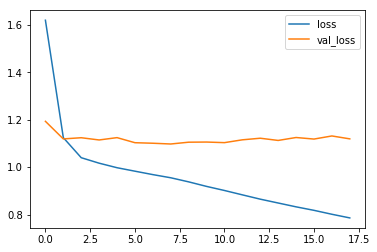

In [44]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [45]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
# i.e. h(1), ..., h(Tx)
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# no need to loop over attention steps this time because there is only one step
context = one_step_attention(encoder_outputs_as_input, initial_s)

# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

# lstm and final dense
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)


# note: we don't really need the final stack and tranpose
# because there's only 1 output
# it is already of size N x D
# no need to make it 1 x N x D --> N x 1 x D



# create the model object
decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s, 
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)


In [46]:
# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [47]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  enc_out = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))
  
  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']


  # [s, c] will be updated in each loop iteration
  s = np.zeros((1, LATENT_DIM_DECODER))
  c = np.zeros((1, LATENT_DIM_DECODER))


  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
        

    # Get next word
    idx = np.argmax(o.flatten())

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

  return ' '.join(output_sentence)

In [ ]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input sentence:', input_texts[i])
  print('Predicted translation:', translation)
  print('Actual translation:', target_texts[i])

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break


-
Input sentence: pleasantly surprised find item delivered day order speediest delivery date probably helps location near everything looks described pictured happy done business seller gingerbread house carefully packaged not harm fragile pieces inside excited give item gift
Predicted translation: not dop
Actual translation: rudolph gingerbread house <eos>
Continue? [Y/n]Y
-
Input sentence: month old male shih tzu brought home breeder kept pro plan puppy tiny dry kibble bag almost finished cups left bag began walking away bowl soon put test rolled morsels across tile floor kitchen see would happen would eat pieces go bring one squeaker toys play happy not want play food game get eat went got blue buffalo dry puppy food lamb oatmeal formula bigger size kibbles seemed liked bigger sized items chew harder antioxidant bits since teething chewing dentabones venison antler lamb lung chips comfort got quarter food left bag would walk away bowl went almost days still small bowel movements urin